In [46]:
# Customize stuff globally

# Location of the USDA database (Len's Docker image)
IP='172.18.153.252'
PORT = 6306
# Authentication information for Plotly
PLOTLY_USER = ''
PLOTLY_AUTH = ''


In [47]:
# Function definitions for the rest of the workbook
import mysql.connector
import pandas as pd
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import numpy as np

def connect():
    return(mysql.connector.connect(
       host=IP,
       port=PORT,
       user="root",
       passwd="admin",
       database="fndds",
    ))

def get_data(query):
    db = connect()
    cur = db.cursor()
    cur.execute(query)
    data = cur.fetchall()
    db.close()
    return(pd.DataFrame(data))
    
def columns():
    return(['food_code', 'food_desc', 'food_group_code', 'food_group_desc',
    'is_animal', 'is_fruit', 'is_vegetable', 'is_dairy', 'is_white_meat',
    'is_red_meat', 'is_nut_or_seed', 'is_legume',
    'pct_water', 'pct_procnt', 'pct_chocdf', 'pct_fibtg', 'pct_ca', 'pct_fe', 'pct_mg', 'pct_p',
    'pct_k', 'pct_na', 'pct_zn', 'pct_cu', 'pct_mn', 'pct_se', 'pct_vitc', 'pct_thia', 'pct_ribf',
    'pct_nia', 'pct_vitb6a', 'pct_fol', 'pct_choln', 'pct_vitb12', 'pct_vita_rae', 'pct_tocpha',
    'pct_vitd', 'pct_vitk1', 'pct_f18d2', 'pct_f18d3',])

def fndds_query():
    return("""SELECT
            food.food_code, main_food_description
            ,LEFT(food.food_code, 2) AS food_group_code
            ,food_coding_scheme.description AS food_group_description
            ,LEFT(food.food_code, 2) IN (11, 12, 14, 20, 21, 22, 23, 24, 31, 32) AS is_animal
            ,LEFT(food.food_code, 2) IN (61, 62, 63) AS is_fruit
            ,LEFT(food.food_code, 2) IN (71, 72, 73, 74, 75) AS is_vegetable
            ,LEFT(food.food_code, 2) IN (11, 12, 14) AS is_dairy
            ,LEFT(food.food_code, 2) IN (22, 24) AS is_white_meat
            ,LEFT(food.food_code, 2) IN (21, 23) AS is_red_meat
            ,LEFT(food.food_code, 2) IN (42, 43) AS is_nut_or_seed
            ,LEFT(food.food_code, 2) IN (41) AS is_legume
            ,food.water/dri.water AS pct_water
            ,food.procnt/dri.procnt AS pct_procnt
            ,food.chocdf/dri.chocdf AS pct_chocdf
            ,food.fibtg/dri.fibtg AS pct_fibtg
            ,food.ca/dri.ca AS pct_ca
            ,food.fe/dri.fe AS pct_fe
            ,food.mg/dri.mg AS pct_mg
            ,food.p/dri.p AS pct_p
            ,food.k/dri.k AS pct_k
            ,food.na/dri.na AS pct_na
            ,food.zn/dri.zn AS pct_zn
            ,food.cu/dri.cu AS pct_cu
            ,food.mn/dri.mn AS pct_mn
            ,food.se/dri.se AS pct_se
            ,food.vitc/dri.vitc AS pct_vitc
            ,food.thia/dri.thia AS pct_thia
            ,food.ribf/dri.ribf AS pct_ribf
            ,food.nia/dri.nia AS pct_nia
            ,food.vitb6a/dri.vitb6a AS pct_vitb6a
            ,food.fol/dri.fol AS pct_fol
            ,food.choln/dri.choln AS pct_choln
            ,food.vitb12/dri.vitb12 AS pct_vitb12
            ,food.vita_rae/dri.vita_rae AS pct_vita_rae
            ,food.tocpha/dri.tocpha AS pct_tocpha
            ,food.vitd/dri.vitd AS pct_vitd
            ,food.vitk1/dri.vitk1 AS pct_vitk1
            ,food.f18d2/dri.f18d2 AS pct_f18d2
            ,food.f18d3/dri.f18d3 AS pct_f18d3
        FROM
            fndds.fndds_nut_val_flat AS food
            JOIN dietary_reference_intake.dietary_reference_intake_flat AS dri
            JOIN fndds.food_coding_scheme ON prefix = LEFT(food.food_code, 2)
            JOIN (
                SELECT food_code, count(*) AS count
                FROM fndds_ingred
                GROUP BY food_code
                HAVING count = 1
            ) AS one_ingred ON one_ingred.food_code = food.food_code
            LEFT JOIN len.food_clusters AS clust ON clust.food_code = food.food_code
        WHERE
            age_from = 31 AND sex = 'Male' AND type = 'recommended'
            AND clust.food_code IS NULL
            AND LEFT(food.food_code, 2) NOT IN (13, 27, 28, 32, 33, 35, 44, 53, 54, 55, 57, 58, 67, 76, 77, 91, 92, 93, 94)
            AND LEFT(food.food_code, 3) NOT IN (110, 116, 117, 131, 132, 133, 134, 144, 145, 146, 147, 217, 228, 234, 247, 415, 416, 419, 423, 716, 717, 718, 754, 756, 915, 916, 917, 918)
        UNION DISTINCT
        SELECT
            clusters.cluster_id AS food_code, -- If less than 11000000, won't clash with food codes
            cluster_description AS main_food_description
            ,LEFT(fcs.prefix, 2) AS food_group_code
            ,fcs.description
            ,LEFT(fcs.prefix, 2) IN (11, 12, 14, 20, 21, 22, 23, 24, 31, 32) AS is_animal
            ,LEFT(fcs.prefix, 2) IN (61, 62, 63) AS is_fruit
            ,LEFT(fcs.prefix, 2) IN (71, 72, 73, 74, 75) AS is_vegetable
            ,LEFT(fcs.prefix, 2) IN (11, 12, 14) AS is_dairy
            ,LEFT(fcs.prefix, 2) IN (22, 24) AS is_white_meat
            ,LEFT(fcs.prefix, 2) IN (21, 23) AS is_red_meat
            ,LEFT(fcs.prefix, 2) IN (42, 43) AS is_nut_or_seed
            ,LEFT(fcs.prefix, 2) IN (41) AS is_legume
            ,food.water/dri.water AS pct_water
            ,food.procnt/dri.procnt AS pct_procnt
            ,food.chocdf/dri.chocdf AS pct_chocdf
            ,food.fibtg/dri.fibtg AS pct_fibtg
            ,food.ca/dri.ca AS pct_ca
            ,food.fe/dri.fe AS pct_fe
            ,food.mg/dri.mg AS pct_mg
            ,food.p/dri.p AS pct_p
            ,food.k/dri.k AS pct_k
            ,food.na/dri.na AS pct_na
            ,food.zn/dri.zn AS pct_zn
            ,food.cu/dri.cu AS pct_cu
            ,food.mn/dri.mn AS pct_mn
            ,food.se/dri.se AS pct_se
            ,food.vitc/dri.vitc AS pct_vitc
            ,food.thia/dri.thia AS pct_thia
            ,food.ribf/dri.ribf AS pct_ribf
            ,food.nia/dri.nia AS pct_nia
            ,food.vitb6a/dri.vitb6a AS pct_vitb6a
            ,food.fol/dri.fol AS pct_fol
            ,food.choln/dri.choln AS pct_choln
            ,food.vitb12/dri.vitb12 AS pct_vitb12
            ,food.vita_rae/dri.vita_rae AS pct_vita_rae
            ,food.tocpha/dri.tocpha AS pct_tocpha
            ,food.vitd/dri.vitd AS pct_vitd
            ,food.vitk1/dri.vitk1 AS pct_vitk1
            ,food.f18d2/dri.f18d2 AS pct_f18d2
            ,food.f18d3/dri.f18d3 AS pct_f18d3
        FROM
            len.clusters
            JOIN fndds.food_coding_scheme fcs ON clusters.prefix = fcs.prefix
            JOIN len.cluster_nutrients AS food USING(cluster_id)         
            JOIN dietary_reference_intake.dietary_reference_intake_flat AS dri
        WHERE
            age_from = 31 AND sex = 'Male' AND type = 'recommended'
            AND LEFT(fcs.prefix, 2) NOT IN (13, 27, 28, 32, 33, 35, 44, 53, 54, 55, 57, 58, 67, 76, 77, 91, 92, 93, 94)
            AND LEFT(fcs.prefix, 3) NOT IN (110, 116, 117, 131, 132, 133, 134, 144, 145, 146, 147, 217, 228, 234, 247, 415, 416, 419, 423, 716, 717, 718, 754, 756, 915, 916, 917, 918)
        ;""")

# Graph the results for selected food groups
def scatterplot_1d(data, mask):
    tls.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_AUTH)
    
    traces = []
    #names = ['Vegetables', 'Fruits', 'Nuts, Seeds, and Legumes', 'Dairy', 'White Meat', 'Red Meat']
    #names = ['Plant', 'Animal']
    names = ['Low', 'Medium', 'High']

    for n in range(max(mask)+1):
        x = data[mask==n,0]
        y = np.full((1,len(x)), n).flatten()
        trace = Scatter(
            x=x,
            y=y,
            mode='markers',
            name=names[n],
            marker=Marker(
                size=12,
                line=Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
            opacity=0.5))
        traces.append(trace)

    MyLayout = Layout(xaxis=layout.XAxis(showline=False),
                    yaxis=layout.YAxis(showline=False))
    return Figure(data=traces, layout=MyLayout)

# Graph the given points, colored by label
def scatterplot_2d(data, labels):
    tls.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_AUTH)
    
    traces = []
    names = list(set(labels))
    
    for name in names:
        x = data[labels==name,0]
        y = data[labels==name,1]
        trace = Scatter(
            x=x,
            y=y,
            mode='markers',
            name=name,
            marker=Marker(
                size=12,
                line=Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
            opacity=0.5))
        traces.append(trace)

    MyLayout = Layout(xaxis=layout.XAxis(showline=False),
                    yaxis=layout.YAxis(showline=False))
    return Figure(data=traces, layout=MyLayout)

# Draw a graph of the best decision tree
from sklearn.tree import export_graphviz
from IPython.display import display

# Export as dot file
def graph_tree(tree, columns, class_labels):
    export_graphviz(tree, out_file='tree.dot', 
                    feature_names = columns,
                    class_names = class_labels,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, special_characters=True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    return(Image(filename = 'tree.png'))

In [48]:
# Authors: Mathew Kallada
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================

This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import linkage_tree

def plot_dendrogram(model, distance=None, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    if distance is None:
        distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [49]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [53]:
# Lookup food data from the DB
data = get_data(fndds_query())
data.columns = columns()
nutrients = data.columns[13:]

# Strip out any records with no nutritional value at all
data = data[np.linalg.norm(data.loc[:, 'pct_procnt':], axis=1) != 0]
data.reset_index(drop=True, inplace=True)

foods = data.iloc[:, 1]
X = data.loc[:, 'pct_procnt':]

# Define the classes and their labels
y = data.loc[:, 'food_group_code']
labels = data.loc[:, 'food_group_desc']

print(X.shape)

(587, 27)


In [54]:
# Import library to do agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# Group foods into two clusters based on nutrients (the default number of clusters)
nut_cluster = AgglomerativeClustering(n_clusters=1, affinity='cosine', linkage='complete').fit(X.T)
children, n_components, n_leaves, parents, nut_distance = linkage_tree(X.T, n_clusters=1, affinity='cosine', linkage='complete', return_distance=True)

food_cluster = AgglomerativeClustering(n_clusters=1,).fit(X)
children, n_components, n_leaves, parents, food_distance = linkage_tree(X, n_clusters=1, return_distance=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:

Partial build of the tree is implemented only for structured clustering (i.e. with explicit connectivity). The algorithm will build the full tree and only retain the lower branches required for the specified number of clusters

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Partial build of the tree is implemented only for structured clustering (i.e. with explicit connectivity). The algorithm will build the full tree and only retain the lower branches required for the specified number of clusters



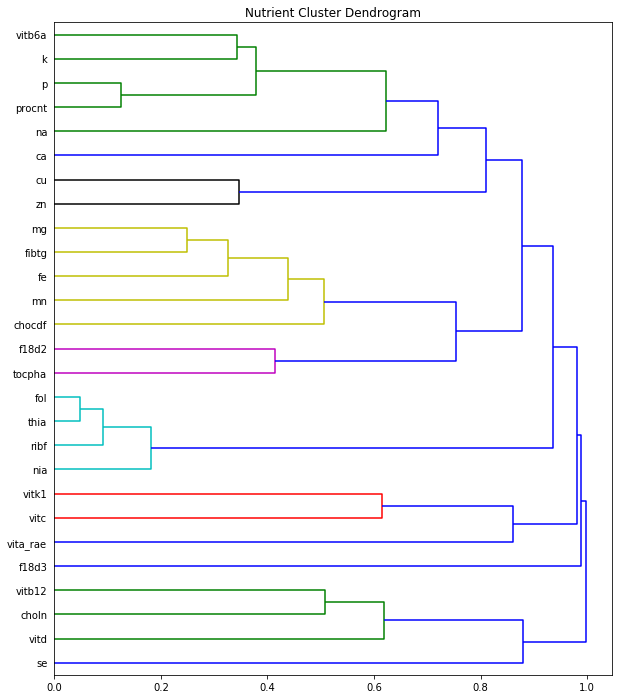

In [55]:
plt.title('Nutrient Cluster Dendrogram')
plt.rcParams["figure.figsize"] = [10, 12]
plot_dendrogram(
    nut_cluster, 
    distance=nut_distance,
    labels=[nut[4:] for nut in nutrients], 
    orientation='right', 
    distance_sort='descending',
    show_leaf_counts=True)
plt.show()

In [57]:
plt.title('Food Cluster Dendrogram (euclidean)')
plt.rcParams["figure.figsize"] = [32, 640]
plot_dendrogram(
    food_cluster, 
    distance=food_distance,
    labels=[label[:40] for label in foods], 
    orientation='right', 
    distance_sort=True,
    leaf_font_size=8,
    show_contracted=True,
    show_leaf_counts=True)
plt.show()

In [58]:
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(X, 'ward')

max_d = 0.015
clusters = fcluster(Z, max_d, criterion='distance')
counts = [ len(X[clusters==n]) for n in range(max(clusters)) ]
synonyms = [i for i in range(max(clusters)) if counts[i] > 1]

frames = []
for i in synonyms:
    records = data[['food_code','food_desc']][clusters==i]
    nuts = X[clusters==i]
    records['cluster_id'] = i
    frames.append(pd.concat((records,nuts), axis=1))

# Combine the results and renumber from 0
results = pd.concat(frames)
results.reset_index(drop=True, inplace=True)

# Calculate the vector norms of the nutrition info
norms = pd.DataFrame(np.linalg.norm(results.loc[:, 'pct_procnt':], axis=1))
norms.columns = ['vector_norm']
results = pd.concat((results,norms),axis=1)

In [59]:
results.to_csv(path_or_buf="/mnt/synonyms.csv")

In [60]:
results

,food_code,food_desc,cluster_id,pct_procnt,pct_chocdf,pct_fibtg,pct_ca,pct_fe,pct_mg,pct_p,...,pct_fol,pct_choln,pct_vitb12,pct_vita_rae,pct_tocpha,pct_vitd,pct_vitk1,pct_f18d2,pct_f18d3,vector_norm
0,63101000,"Apple, raw",195,0.004643,0.106231,0.063158,0.006,0.01500,0.011905,0.015714,...,0.0075,0.006182,0.0,0.003333,0.012000,0.0,0.018333,0.002529,0.005625,0.149908
1,63101320,"Apple, baked, unsweetened",195,0.005000,0.114231,0.068421,0.006,0.01625,0.011905,0.017143,...,0.0050,0.006727,0.0,0.003333,0.012667,0.0,0.020000,0.002706,0.006250,0.156158


In [62]:
norms = pd.DataFrame(np.linalg.norm(X.loc[:, 'pct_procnt':], axis=1))
norms.columns = ['norm']
data_with_norms = pd.concat((data[['food_code','food_desc']],norms,data.loc[:,'pct_procnt':]), axis=1)
data_with_norms.sort_values(by='norm')

,food_code,food_desc,norm,pct_procnt,pct_chocdf,pct_fibtg,pct_ca,pct_fe,pct_mg,pct_p,...,pct_vitb6a,pct_fol,pct_choln,pct_vitb12,pct_vita_rae,pct_tocpha,pct_vitd,pct_vitk1,pct_f18d2,pct_f18d3
503,82101500,Coconut oil,0.100322,0.000000,0.000000,0.000000,0.001,0.00625,0.000000,0.000000,...,0.000000,0.0000,0.000545,0.000000,0.000000,0.007333,0.000000,0.005000,0.099000,0.011875
341,63137120,"Pear, cooked or canned, unsweetened, water pack",0.101728,0.003393,0.060077,0.042105,0.004,0.02625,0.009524,0.010000,...,0.010769,0.0025,0.006182,0.000000,0.000000,0.005333,0.000000,0.002500,0.000412,0.000000
370,64101010,Apple cider,0.103100,0.001786,0.086923,0.005263,0.008,0.01500,0.011905,0.010000,...,0.013846,0.0000,0.003273,0.000000,0.000000,0.000667,0.000000,0.000000,0.001941,0.004375
273,61207200,"Lime juice, 100%, canned or bottled",0.113461,0.004464,0.051462,0.010526,0.012,0.02875,0.016667,0.014286,...,0.020769,0.0200,0.009273,0.000000,0.001111,0.008000,0.000000,0.004167,0.002471,0.013750
382,64401000,Vinegar,0.114306,0.000000,0.007154,0.000000,0.007,0.02500,0.011905,0.011429,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
335,63135120,"Peach, cooked or canned, unsweetened, water pack",0.121801,0.007857,0.047000,0.034211,0.002,0.04000,0.011905,0.014286,...,0.014615,0.0075,0.007455,0.000000,0.030000,0.032667,0.000000,0.014167,0.001588,0.000625
579,265,Papaya juice or nectar,0.132330,0.003036,0.111615,0.015789,0.010,0.04250,0.007143,0.000000,...,0.006923,0.0050,0.003636,0.000000,0.020000,0.016000,0.000000,0.006667,0.000412,0.017500
343,63137170,"Pear, cooked or canned, juice pack",0.136696,0.006071,0.099538,0.042105,0.009,0.03625,0.016667,0.017143,...,0.010769,0.0025,0.006182,0.000000,0.000000,0.005333,0.000000,0.002500,0.000882,0.000000
350,63143120,"Plum, cooked or canned, unsweetened, water pack",0.137364,0.006964,0.084846,0.023684,0.007,0.02000,0.011905,0.018571,...,0.020769,0.0075,0.002364,0.000000,0.051111,0.012000,0.000000,0.035833,0.000118,0.000000
580,267,"Watermelon, raw or juice",0.141630,0.010893,0.058077,0.010526,0.007,0.03000,0.023810,0.015714,...,0.034615,0.0075,0.007455,0.000000,0.031111,0.003333,0.000000,0.000833,0.002941,0.000000
